In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.gofplots import qqplot

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Read the data

In [2]:
df_sgd = pd.read_csv('Data/DEXSIUS_19810102_20180504.csv', header=0, index_col='DATE')
df_jpy = pd.read_csv('Data/DEXJPUS_19710104_20180504.csv', header=0, index_col='DATE')

### Prepare the data

- Let the period of analysis be from Year 2000 and beyond.
- For any data value that is an NaN, do a forward fill. This is reasonable as the exchange rate will be the last known exchange rate if it's a weekend or public holiday.

In [3]:
df_sgd = df_sgd['2000-01-01':]
df_sgd.DEXSIUS = pd.to_numeric(df_sgd.DEXSIUS, errors='coerce')
df_sgd = df_sgd.fillna(method='ffill')

In [4]:
df_jpy = df_jpy['2000-01-01':]
df_jpy.DEXJPUS = pd.to_numeric(df_jpy.DEXJPUS, errors='coerce')
df_jpy = df_jpy.fillna(method='ffill')

In [5]:
df = df_sgd.join(df_jpy, how='outer')

In [6]:
df['SGDJPY'] = df.DEXJPUS / df.DEXSIUS

In [7]:
df_pc = df.pct_change()

In [8]:
df.head()

,DEXSIUS,DEXJPUS,SGDJPY
DATE,,,
2000-01-03,1.6563,101.70,61.401920
2000-01-04,1.6535,103.09,62.346538
2000-01-05,1.6560,103.77,62.663043
2000-01-06,1.6655,105.19,63.158211
2000-01-07,1.6625,105.17,63.260150


In [9]:
df_pc.head()

,DEXSIUS,DEXJPUS,SGDJPY
DATE,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.001691,0.013668,0.015384
2000-01-05,0.001512,0.006596,0.005077
2000-01-06,0.005737,0.013684,0.007902
2000-01-07,-0.001801,-0.000190,0.001614


### Time Series Plots for SGD and JPY Exchange Rates

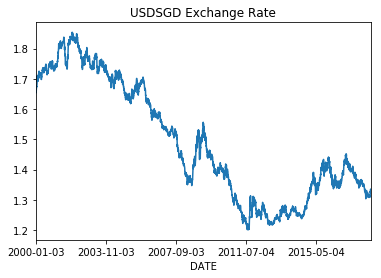

In [10]:
df['DEXSIUS'].plot(title='USDSGD Exchange Rate')

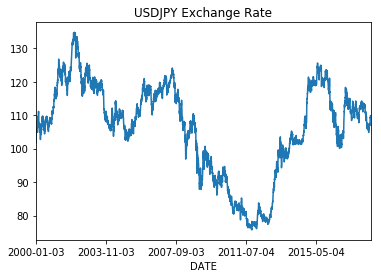

In [11]:
df['DEXJPUS'].plot(title='USDJPY Exchange Rate')

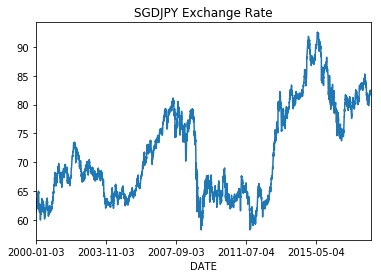

In [12]:
df['SGDJPY'].plot(title='SGDJPY Exchange Rate')

### Time Series Plot for SGD and JPY Exchange Rate Percent Changes

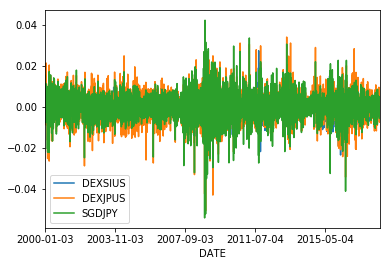

In [13]:
df_pc.plot()

In [14]:
df_pc.describe()

,DEXSIUS,DEXJPUS,SGDJPY
count,4784.000000,4784.000000,4784.000000
mean,-0.000040,0.000035,0.000079
std,0.003294,0.006320,0.006136
min,-0.023567,-0.050820,-0.054284
25%,-0.001779,-0.003276,-0.002911
50%,0.000000,0.000000,0.000000
75%,0.001620,0.003479,0.003366
max,0.027316,0.033993,0.042212


Before we go on and apply statistical concepts on these series, lets look at how normal our returns are by testing its normality.

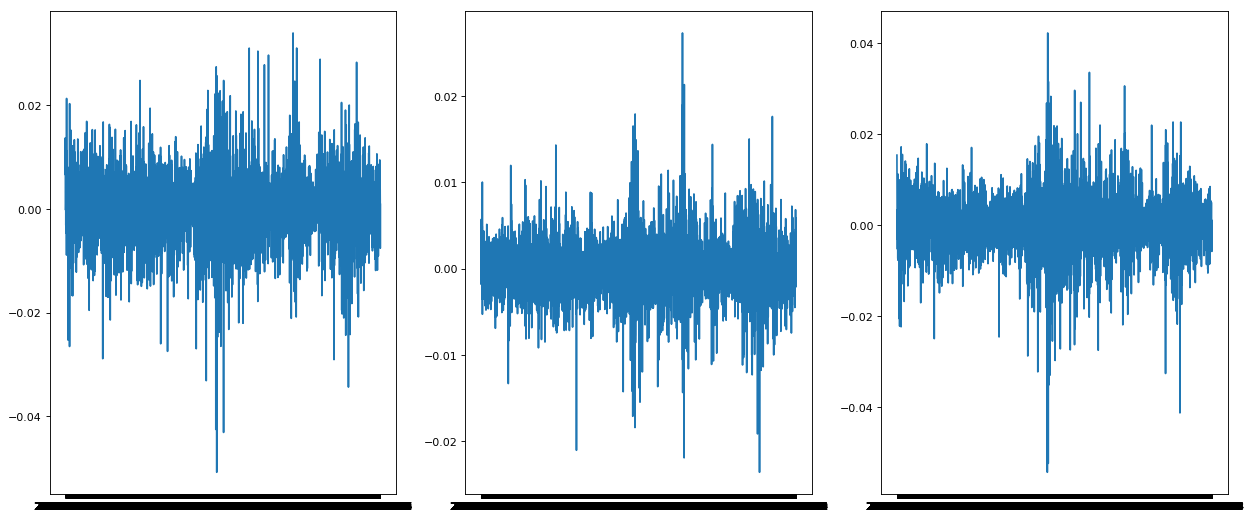

In [15]:
fig=plt.figure(figsize=(19, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.plot(df_pc['DEXJPUS'])
plt.subplot(1, 3, 2)
plt.plot(df_pc['DEXSIUS'])
plt.subplot(1, 3, 3)
plt.plot(df_pc['SGDJPY'])

Visual inspection shows that all 3 pairs of returns 
look stationary, which infer white noise.

### Correlation of each pair of series

Correlation between returns of USDJPY and USDSGD: 0.3147026684844892


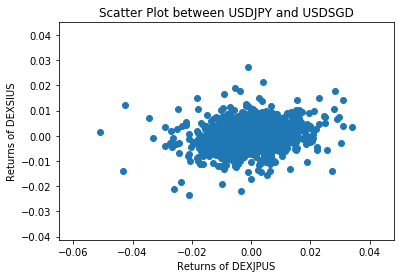

In [16]:
print('Correlation between returns of USDJPY and USDSGD: {0}'.format(df_pc['DEXJPUS'].corr(df_pc['DEXSIUS'])))
_ = plt.xlabel('Returns of DEXJPUS')
_ = plt.ylabel('Returns of DEXSIUS')
_ = plt.title('Scatter Plot between USDJPY and USDSGD')
_ = plt.scatter(x=df_pc['DEXJPUS'], y=df_pc['DEXSIUS'])

Correlation between returns of USDJPY and SGDJPY: 0.8606339142171909


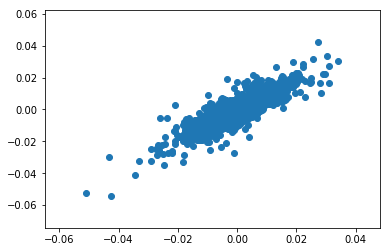

In [17]:
print('Correlation between returns of USDJPY and SGDJPY: {0}'.format(df_pc['DEXJPUS'].corr(df_pc['SGDJPY'])))
_ = plt.scatter(x=df_pc['DEXJPUS'], y=df_pc['SGDJPY'])

Correlation between returns of USDSGD and SGDJPY: -0.21247373056812982


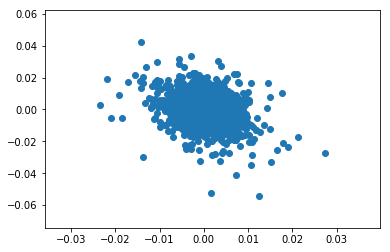

In [18]:
print('Correlation between returns of USDSGD and SGDJPY: {0}'.format(df_pc['DEXSIUS'].corr(df_pc['SGDJPY'])))
_ = plt.scatter(x=df_pc['DEXSIUS'], y=df_pc['SGDJPY'])

Only the correlation between the returns of USDJPY and SGDJPY exhibits a noticeably strong positive correlation at 0.86. Correlation between the other pairs of returns are weak.

### Autocorrelation with lag 1 on Daily, Weekly, Monthly Resampled Data

#### Autocorrelation with lag 1 on Daily data

In [19]:
df_pc['DEXJPUS'].autocorr()

-0.019499421909458393

In [20]:
df_pc['DEXSIUS'].autocorr()

-0.019814188808621517

In [21]:
df_pc['SGDJPY'].autocorr()

-0.03666853833534806

The daily autocorrelation of all 3 returns on exchange rates are negative, indicating a mean reverting behavior (Buy Low Sell High strategy??). This is quite surprising as the returns on commodities and currencies usually exhibit a positive autocorrelation. Returns on stocks generally have a negative autocorrelation, indicating a mean-reverting behavior.

#### Autocorrelation with lag 1 on Weekly data

In [22]:
df_pc.index = pd.to_datetime(df_pc.index)
df_pc_weekly = df_pc.dropna().resample(rule='W').last()
df_pc_weekly.head()

,DEXSIUS,DEXJPUS,SGDJPY
DATE,,,
2000-01-09,-0.001801,-0.000190,0.001614
2000-01-16,0.003114,-0.002168,-0.005265
2000-01-23,0.002684,-0.004647,-0.007311
2000-01-30,0.010041,0.021352,0.011198
2000-02-06,0.000295,-0.003521,-0.003815


In [23]:
df_pc_weekly['DEXSIUS'].autocorr()

0.030889939974444586

In [24]:
df_pc_weekly['DEXJPUS'].autocorr()

-0.03553076790711168

In [25]:
df_pc_weekly['SGDJPY'].autocorr()

-0.035972628830940184

#### Autocorrelation with lag 1 on Monthly data

In [26]:
df_pc_monthly = df_pc.resample('M').last()

In [27]:
df_pc_monthly['DEXSIUS'].autocorr()

0.02578038077698777

In [28]:
df_pc_monthly['DEXJPUS'].autocorr()

0.036244565553334225

In [29]:
df_pc_monthly['SGDJPY'].autocorr()

-0.00521589218394799

### Autocorrelation with ACF()

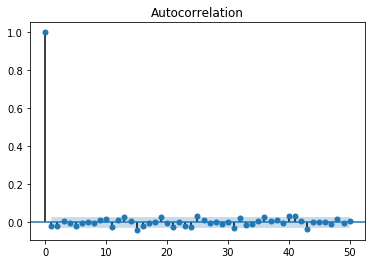

In [30]:
_ = plot_acf(df_pc['DEXJPUS'].dropna(), lags=50, alpha=0.05)

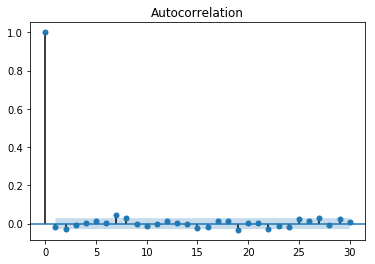

In [31]:
_ = plot_acf(df_pc['DEXSIUS'].dropna(), lags=30, alpha=0.05)

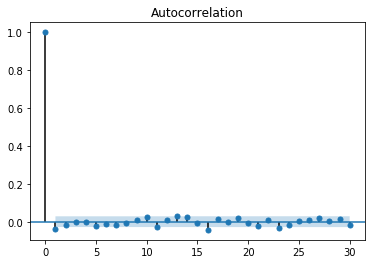

In [32]:
_ = plot_acf(df_pc['SGDJPY'].dropna(), lags=30, alpha=0.05)

Looking at the ACF with lags=30 and alpha=0.05, reveals no significiant lags that shows any autocorrelation. This implies that past data is not strongly able to forecast the future.

## Seasonility

### >> Are there any months where Volatility of Returns is consistently higher than other months?

In [33]:
index_months = df_pc.dropna().index.month

In [37]:
# group by months - find the std by months
df_std_by_months = df_pc.dropna().groupby(index_months).std()
df_std_by_months

,DEXSIUS,DEXJPUS,SGDJPY
DATE,,,
1,0.003228,0.006597,0.006006
2,0.002947,0.006256,0.005955
3,0.003239,0.007284,0.006877
4,0.003232,0.006298,0.006119
5,0.003387,0.006087,0.005812
6,0.003423,0.006584,0.006125
7,0.002978,0.006041,0.005444
8,0.003048,0.006049,0.005895
9,0.003686,0.005977,0.006255


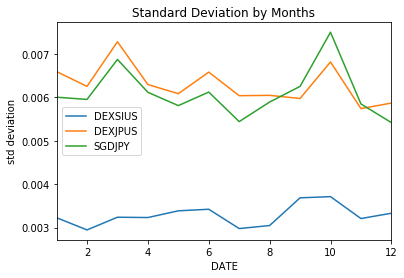

In [35]:
_ = df_std_by_months.plot()
_ = plt.ylabel('std deviation')
_ = plt.title('Standard Deviation by Months')

### Interesting Insights from this graph:
- SGD volatility is the lowest and gradually increases throughout the year, with the highest in Sept/October months.
- JPY volatility gradually decreases during the year, with 3 spikes in March, June and October.
- SGDJPY volatility is highest during the month of October

> Why is this behavior in volatility observed for these currencies during these months?

However, before we jump into a conclusion that this behavior is repeatable in future, lets confirm if this cycle holds true for every year. Lets test for seasonality.


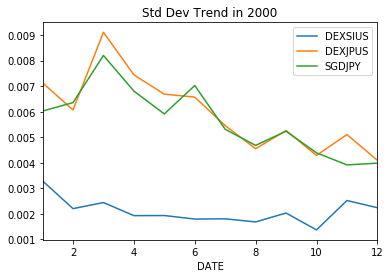

In [49]:
# Is the above graph true for all years?
df_std_by_months_years = df_pc.dropna().groupby([df_pc.dropna().index.year, df_pc.dropna().index.month]).std()
# df_std_by_months_years.head(24)
_ = df_std_by_months_years.loc[2000].plot(title='Std Dev Trend in 2000')

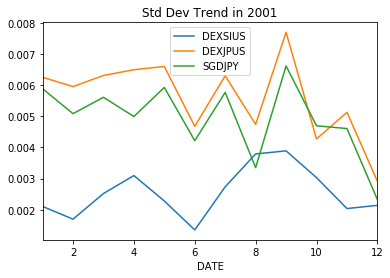

In [50]:
_ = df_std_by_months_years.loc[2001].plot(title='Std Dev Trend in 2001')

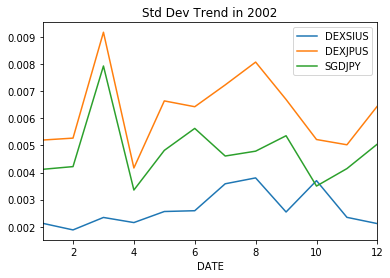

In [51]:
_ = df_std_by_months_years.loc[2002].plot(title='Std Dev Trend in 2002')

### Are there any months which has more Upticks, more Downticks or more NoChange in Returns than other months?